## Introduction

> This notebook used the [Fruit 360](https://www.kaggle.com/moltean/fruits) dataset.

Instead of using CNN block to train the model, I tried to use the Vision Transformer (ViT) which is based on the paper [Image is worth 16 x 16 words](https://arxiv.org/abs/2010.11929). The model has already been build in the [**transformers**](https://huggingface.co/transformers/model_doc/vit.html) package.

Below are some resources to help readers to know more about ViT
* [Paper](https://www.kaggle.com/moltean/fruits)
* [Video](https://youtu.be/TrdevFK_am4)
* [Implement ViT from scratch using PyTorch](https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632)

### Download the trained model

I had put the trained weight on Google Drive. Users can download it by running below two blocks

In [1]:
!pip install gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9681 sha256=7d9edf3ec7edcba0da15a0e47bf4aeef2ba374885568035d72a1675760298ac1
  Stored in directory: /root/.cache/pip/wheels/ba/e0/7e/726e872a53f7358b4b96a9975b04e98113b005cd8609a63abc
Successfully built gdown


In [2]:
# Download the model weight if users want to use the
#  trained model for this task (Fruits 360)
!gdown  https://drive.google.com/uc?id=1YfVZ7aUefO8Zx5UVnyJg8nIuOLyNcx-Y

Downloading...
From: https://drive.google.com/uc?id=1YfVZ7aUefO8Zx5UVnyJg8nIuOLyNcx-Y
To: /kaggle/working/model.pt
347MB [00:02, 150MB/s]  


In [3]:
# Pytorch
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Build up the pretrained transformers model
from transformers import ViTFeatureExtractor, ViTModel

# Plot tool
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

In [4]:
# Set up device and training hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
latent_dim = 256
epochs = 1
learning_rate = 5e-4

print(device)

cuda


## Build up dataset and dataloader

In [5]:
# Add the transformation of image
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

# Path for training and validation dataset
training_path = "../input/fruits/fruits-360/Training"
validating_path = "../input/fruits/fruits-360/Test"

In [6]:
# Create train, val dataset
training_dataset = ImageFolder(training_path,
                               transform=data_transforms)
validating_dataset = ImageFolder(validating_path,
                                 transform=data_transforms)

# Create train, val dataloader
training_dataloader = DataLoader(training_dataset,
                                 batch_size=batch_size,
                                 shuffle=True)
val_dataloader = DataLoader(validating_dataset,
                            batch_size=batch_size,
                            shuffle=True)

## How our data look like?

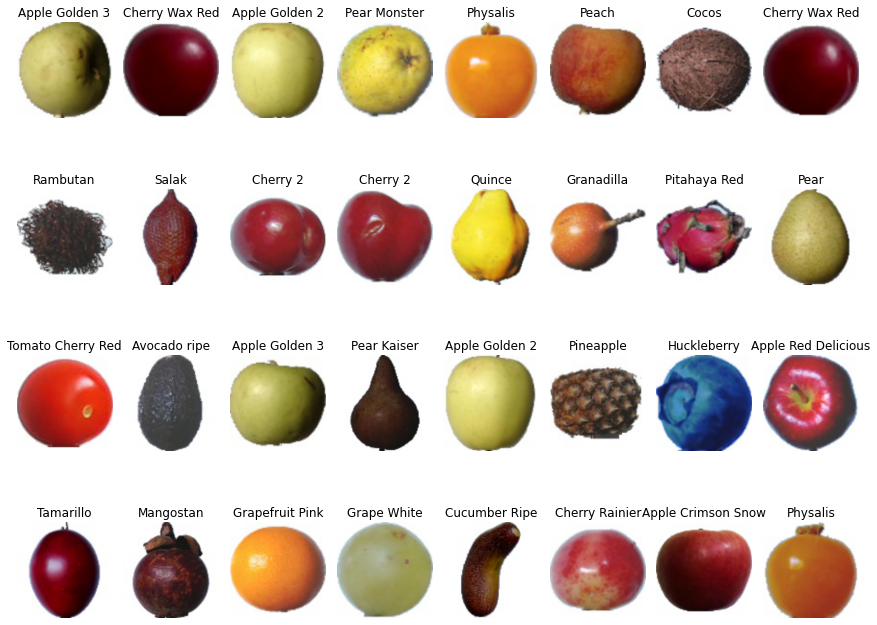

In [7]:
image_size = 32

# Get the image from dataloader
show_images, show_labels = next(iter(training_dataloader))
show_images = show_images[:image_size]
show_labels = show_labels[:image_size]

ncols = 8
nrows = int(image_size / ncols) + 1

# Set up the figure size
plt.figure(figsize=(12, 12))


def inverse_normalized(image):
    # Clamp the value to (0.0, 1.0) for floats
    image = torch.clamp(input=image * 0.5 + 0.5,
                        min=0.0,
                        max=1.0)
    return image


for idx in range(len(show_images)):
    # Set up the subplot
    plt.subplot(nrows, ncols, idx + 1)
    
    # Close the axis and plot the image
    plt.axis("off")
    # Note that the label is change into integer, we should change it back to category
    plt.title(training_dataset.classes[show_labels[idx].item()])
    # Note that the image channel of tensor is: (channel, width, height)
    # We need to change it to (width, height, channel) which we use permute to realize it
    plt.imshow(inverse_normalized(show_images[idx].permute(1, 2, 0)))

# Avoid overlapping of different titles
plt.tight_layout()

## Build the model

In [8]:
class CategoryClass(nn.Module):
    def __init__(self, vit, latent_dim, classes_):
        super(CategoryClass, self).__init__()
        
        self.classes_ = classes_
        
        # Set up model architecture
        self.vit = vit
        self.fc_1 = nn.Linear(768, latent_dim)
        self.fc_out = nn.Linear(latent_dim, self.classes_)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, in_data):
        # Type of output `BaseModelOutputWithPooling`
        vit_outputs = self.vit(in_data)
        
        # Shape of pooler_output: (batch_size, hidden_size)
        pooler_output = vit_outputs.pooler_output
        
        # Pass through the linear layout to predict the class
        # Shape of output: (batch_size, classes_)
        outputs = torch.relu(self.fc_1(pooler_output))
        outputs = self.fc_out(self.dropout(outputs))
        
        return outputs

In [9]:
# Set up the pretrained model
vit = ViTModel.from_pretrained('google/vit-base-patch16-224')

Downloading:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Freeze the layers in vit exclude the pooler layers
for param in vit.parameters():
    param.requires_grad = False

vit.pooler.dense.weight.requires_grad = True
vit.pooler.dense.bias.requires_grad = True

In [11]:
# Create the complete model
model = CategoryClass(vit,
                      latent_dim,
                      len(training_dataset.classes)).to(device)

In [12]:
# Set up loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), learning_rate)

In [13]:
# Save the training and validating information
training_loss_history =[]
training_accuracy_history = []
validating_loss_history = []
validating_accuracy_history = []

# We only train one epoch
#  Therefore, we save the batch information
batch_loss_history = []
batch_accuracy_history = []

for epoch in range(epochs):
    # Set to the train mode
    model.train()
    
    train_epoch_loss = 0.0
    train_epoch_accuracy = 0.0
    for idx, (images, labels) in enumerate(training_dataloader):
        # Move the data to the device
        images = images.to(device)
        labels = labels.to(device)
        
        # Pass through the model
        outputs = model(images)
        
        # Count the loss and update the parameters
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Record the training information
        train_epoch_loss += loss.item()
        predict_class = outputs.argmax(dim=-1)
        accuracy = torch.sum(predict_class == labels).item() / labels.shape[0]
        train_epoch_accuracy += accuracy

        # Save the batch information
        batch_loss_history.append(loss.item())
        batch_accuracy_history.append(accuracy)

        # Print batch information
        print(f"Batch {idx + 1} in epoch {epoch + 1}/{epochs}")
        print(f"Average loss: {loss.item()}")
        print(f"Average accuracy {accuracy}")
        
    # Set to the eval mode
    model.eval()
    
    val_epoch_loss = 0.0
    val_epoch_accuracy = 0.0
    
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            # Move data to the device
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            # Pass through model
            val_outputs = model(val_images)
            
            # Count the loss and accuracy
            val_epoch_loss += criterion(val_outputs, val_labels)
            val_predict_class = val_outputs.argmax(dim=-1)
            val_epoch_accuracy += torch.sum(val_predict_class == val_labels).item() / val_labels.shape[0]
            
    # Save the epoch information
    training_loss_history.append(train_epoch_loss / len(training_dataloader))
    training_accuracy_history.append(train_epoch_accuracy / len(training_dataloader))
    validating_loss_history.append(val_epoch_loss / len(val_dataloader))
    validating_accuracy_history.append(val_epoch_accuracy / len(val_dataloader))
    
    # Print the information
    print(f"Epoch {epoch + 1}")
    print(f"Average training loss: {training_loss_history[-1]}, Average validation loss: {validating_loss_history[-1]}")
    print(f"Average training accuracy: {training_accuracy_history[-1]}, Average validation accuracy: {validating_accuracy_history[-1]}")

Batch 1 in epoch 1/1
Average loss: 4.894556522369385
Average accuracy 0.0078125
Batch 2 in epoch 1/1
Average loss: 4.795823097229004
Average accuracy 0.05859375
Batch 3 in epoch 1/1
Average loss: 4.710381507873535
Average accuracy 0.17578125
Batch 4 in epoch 1/1
Average loss: 4.62586784362793
Average accuracy 0.25
Batch 5 in epoch 1/1
Average loss: 4.50379753112793
Average accuracy 0.3125
Batch 6 in epoch 1/1
Average loss: 4.43869686126709
Average accuracy 0.34375
Batch 7 in epoch 1/1
Average loss: 4.253046989440918
Average accuracy 0.4375
Batch 8 in epoch 1/1
Average loss: 4.2378411293029785
Average accuracy 0.37109375
Batch 9 in epoch 1/1
Average loss: 4.140782833099365
Average accuracy 0.37890625
Batch 10 in epoch 1/1
Average loss: 4.00542688369751
Average accuracy 0.45703125
Batch 11 in epoch 1/1
Average loss: 3.8936593532562256
Average accuracy 0.42578125
Batch 12 in epoch 1/1
Average loss: 3.7591071128845215
Average accuracy 0.46875
Batch 13 in epoch 1/1
Average loss: 3.707258462

In [14]:
# Save the model weight
torch.save(model.state_dict(), "model.pt")

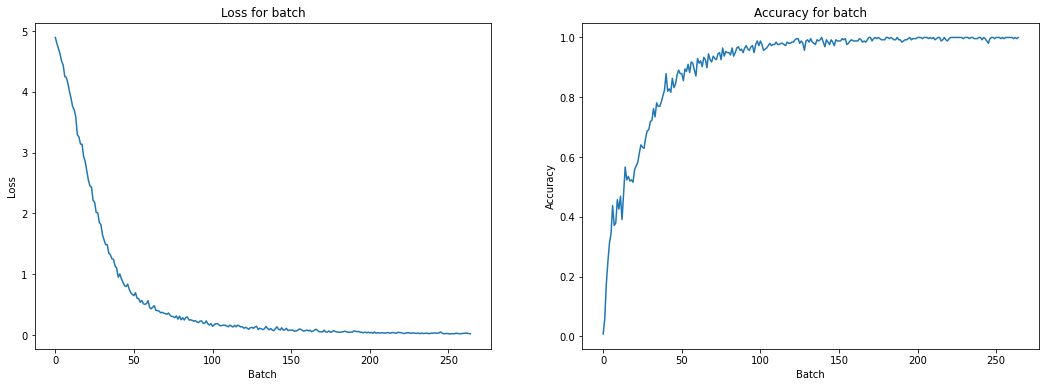

In [15]:
# Plot the loss and accuracy
plt.figure(figsize=(18,6))

# Loss
plt.subplot(1, 2, 1)
plt.title("Loss for batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(batch_loss_history)

# Accuracy
plt.subplot(1, 2, 2)
plt.title("Accuracy for batch")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.plot(batch_accuracy_history)

In [16]:
prediction = []
true_labels = []

# Create the classification report on test dataset
with torch.no_grad():
    for val_images, val_labels in val_dataloader:
        # Move data to the device
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)
        
        # Pass through model
        val_outputs = model(val_images)
        
        # Count the loss and accuracy
        val_predict_class = val_outputs.argmax(dim=-1)

        prediction.extend([predict_class.item() for predict_class in val_predict_class])
        true_labels.extend([val_label.item() for val_label in val_labels])

In [17]:
import pandas as pd

# Output dict for making the report
report = classification_report(true_labels, prediction,
                               output_dict=True,
                               target_names=training_dataset.classes)
report_df = pd.DataFrame(report).transpose()

In [18]:
# Show all columns
pd.set_option("display.max_rows", None)
report_df.head(134)

,precision,recall,f1-score,support
Apple Braeburn,0.901099,1.000000,0.947977,164.000000
Apple Crimson Snow,1.000000,0.729730,0.843750,148.000000
Apple Golden 1,1.000000,1.000000,1.000000,160.000000
Apple Golden 2,1.000000,1.000000,1.000000,164.000000
Apple Golden 3,0.860963,1.000000,0.925287,161.000000
Apple Granny Smith,1.000000,1.000000,1.000000,164.000000
Apple Pink Lady,0.812834,1.000000,0.896755,152.000000
Apple Red 1,0.922619,0.945122,0.933735,164.000000
Apple Red 2,1.000000,0.975610,0.987654,164.000000
Apple Red 3,1.000000,0.944444,0.971429,144.000000
